# Yelp Hotel Reviews: sentiment classification with LogisticRegression

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read in review table from yelp database
import pandas as pd
reviews_df = pd.read_sql_table("review", "sqlite:///yelpHotelData.db")

### Query using SQL if you'd like

In [ ]:
# load sql extension
%load_ext sql

In [ ]:
# Connect to database (or creatge new one if none exists)
%sql sqlite:///yelpHotelData.db

In [ ]:
%%sql
SELECT *
FROM review
LIMIT 3;

In [ ]:
######## EDA

In [ ]:
## Dimensions
print(f"Corpus contains {reviews_df.shape[0]} documents (i.e. individual reviews)")
print(f"Corpus contains {reviews_df.shape[1]} columns")

In [ ]:
## Check out data and columns
reviews_df.head()

In [ ]:
from plotnine import *

In [ ]:
### Get smaller sample of the data to speed up computation later
small_df = reviews_df.sample(n=100000)

In [ ]:
### Are useful reviews also cool?
(ggplot(small_df, aes(x="usefulCount",
                       y="coolCount")) +
geom_point())

In [ ]:
### Are useful reviews also funny?
(ggplot(small_df, aes(x="usefulCount",
                       y="funnyCount")) +
geom_point())

In [ ]:
### Get smaller sample of the data to speed up computation later
small_df = reviews_df.sample(n=10000)

In [14]:
### Remove neutral ratings
small_df = small_df[small_df["rating"] != 3]

In [15]:
### Make sure 3 rating has been removed
pd.crosstab(small_df["rating"], columns="count")

col_0,count
rating,
1,4789
2,9101
4,38561
5,25058


In [18]:
### Create binary label 1=positive rating, 0 negative
import numpy as np
small_df["pos_rev"] = np.where(small_df["rating"] > 4, 1, 0)

In [19]:
### Get percent pos and neg: 32% postiive
pd.crosstab(small_df["pos_rev"], columns="count", normalize=True)

col_0,count
pos_rev,
0,0.676709
1,0.323291


In [20]:
### Create X (features) and Y (target)
sentiment_label = small_df[["pos_rev"]]
sentiment_features = small_df[["reviewContent"]]

In [21]:
### Split data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentiment_features,
                                                    sentiment_label,
                                                   test_size = 0.2,
                                                    random_state=123)

In [24]:
### Import and instantiate vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()

In [25]:
### Vectorize training text
reviews_xtrain = vec.fit_transform(X_train["reviewContent"])

In [26]:
### Vectorize test text
reviews_xtest = vec.transform(X_test["reviewContent"])

### Using Logistic Regression 

In [27]:
### Import cross_val_score and logistic regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [28]:
### Use 5 fold cross validation with logistic regression
scores = cross_val_score(LogisticRegression(), 
                         reviews_xtrain,
                        y_train,
                        cv=5)

In [29]:
print(f"Averge cv accuracy: {np.mean(scores)}")

Averge cv accuracy: 0.736142804470526


In [31]:
### Hyperparameter tuning with GridSearchCV and regularization parameter C
from sklearn.model_selection import GridSearchCV

# Set parameters
param_grid = {"C": [0.001, 0.01, 0.1, 10]}

In [32]:
# Instantiaite grid object
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# Fit
grid.fit(reviews_xtrain, y_train)
print(f"Optimal cross-validation score: {grid.best_score_}")
print(f"Optimal parameters: ", grid.best_params_)

Optimal cross-validation score: 0.7490122492605555
Optimal parameters:  {'C': 0.01}


In [33]:
###
#reviews_xtest = vec.transform(X_test["reviewContent"])

In [34]:
###
print(f"Score on test set: {grid.score(reviews_xtest, y_test)}")

Score on test set: 0.7489356212101664


### Using Naive Bayes: Multinomial

In [35]:
### Import cross_val_score and naive bayes
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

In [36]:
# Instantiate class
gb = MultinomialNB()

In [37]:
scores = cross_val_score(MultinomialNB(), 
                         reviews_xtrain,
                        y_train,
                        cv=5)

In [38]:
print(f"Averge cv accuracy: {np.mean(scores)}")

Averge cv accuracy: 0.7270791883457021


### Using Naive Bayes: BernoulliNB

In [39]:
### Import cross_val_score and naive bayes bernoulli
# differs from multinomial NB’s rule in that it explicitly penalizes
#  the non-occurrence of a feature  that is an indicator for class , 
# where the multinomial variant would simply ignore a non-occurring feature.
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB

In [40]:
scores = cross_val_score(BernoulliNB(), 
                         reviews_xtrain,
                        y_train,
                        cv=5)

In [41]:
scores

array([0.7354459 , 0.7331882 , 0.73776308, 0.72752197, 0.73308604])

In [42]:
print(f"Averge cv accuracy: {np.mean(scores)}")

Averge cv accuracy: 0.7334010380761022


### Comparing LR, MN, BN 

In [43]:
scores_lr = cross_val_score(LogisticRegression(), 
                         reviews_xtrain,
                        y_train,
                        cv=5)

In [45]:
scores_mn = cross_val_score(MultinomialNB(), 
                         reviews_xtrain,
                        y_train,
                        cv=5)

In [46]:
scores_bn = cross_val_score(BernoulliNB(), 
                         reviews_xtrain,
                        y_train,
                        cv=5)

In [47]:
scores_df = pd.DataFrame({
    "model": ["LogReg", "MultiNB", "BernNB"],
    "mean_score": [np.mean(scores_lr),
    np.mean(scores_mn),
    np.mean(scores_bn)]})

In [48]:
scores_df

,model,mean_score
0,LogReg,0.736143
1,MultiNB,0.727079
2,BernNB,0.733401


In [49]:
import seaborn as sns

<AxesSubplot:xlabel='model', ylabel='mean_score'>

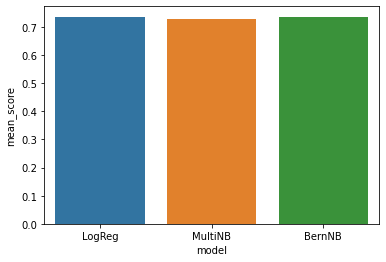

In [50]:
sns.barplot(x="model",
           y="mean_score",
           data=scores_df)

### Evaluate confusion matrix with logreg model

In [51]:
# Model
lr = LogisticRegression()

In [52]:
# Fit model
fitted_mod = lr.fit(reviews_xtrain, y_train)

In [53]:
# Generat predictions with test set
y_pred = fitted_mod.predict(reviews_xtest)

In [54]:
# Assess using relevant metrics: confusion matrix   true/pred   #  no/no |  no/yes
from sklearn.metrics import confusion_matrix                        # yes/no |  yes/yes
print(confusion_matrix(y_test, y_pred))

[[8953 1493]
 [2575 2481]]


In [55]:
# Precision probably more important here 
# (We probably want to focus on negative reviews to improve services so don't want to classify a negative review as positive)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.81     10446
           1       0.62      0.49      0.55      5056

    accuracy                           0.74     15502
   macro avg       0.70      0.67      0.68     15502
weighted avg       0.73      0.74      0.73     15502



## Improving model by adjusting CountVectorizer parameters

### Removing rare words

In [56]:
### Vectorize training text
reviews_xtrain = CountVectorizer().fit_transform(X_train["reviewContent"])

In [57]:
print(f"Number of features: {reviews_xtrain.shape[1]}")

Number of features: 83569


In [58]:
### Vectorize training text, set min_df to 5
reviews_xtrain = CountVectorizer(min_df=5).fit_transform(X_train["reviewContent"])

In [59]:
print(f"Number of features, excluding words that appear in less than 5 documents: {reviews_xtrain.shape[1]}")

Number of features, excluding words that appear in less than 5 documents: 25988


In [60]:
### Testing with smaller feature space, improvement?
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(reviews_xtrain, y_train)
print(f"Optimal cross-validation score: {grid.best_score_}")

Optimal cross-validation score: 0.7488993629415963


### Stopwords

In [61]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw

In [62]:
print(f"Number of stop words in list: {len(esw)}")

Number of stop words in list: 318


In [63]:
import random
print("Some examples of stopwords:")
for i,words in enumerate(random.sample(esw, 10)):
    print(words)

Some examples of stopwords:
every
sincere
what
will
became
always
other
co
amongst
someone


In [64]:
## Remove stopwords
reviews_xtrain = CountVectorizer(min_df=5,
                                stop_words=esw).fit_transform(X_train["reviewContent"])

In [65]:

print(f"Number of features, excluding words that appear in less than 5 documents and stopwords: {reviews_xtrain.shape[1]}")

Number of features, excluding words that appear in less than 5 documents and stopwords: 25686


In [66]:
print(f"There are now {25885-25583} fewer words than last vectorization")

There are now 302 fewer words than last vectorization


### Stopwords in nltk and spacy

In [67]:
#### Stopwords from nltk
from nltk.corpus import stopwords

nltk_sw = stopwords.words("english")

In [68]:
print(f"Number of stop words in list: {len(nltk_sw)}")

Number of stop words in list: 179


In [69]:
#### Stopwrods from spacy
from spacy.lang.en.stop_words import STOP_WORDS as spacy_sw

In [70]:
print(f"Number of stop words in list: {len(spacy_sw)}")

Number of stop words in list: 326


In [71]:
#### Comparing stopword lists
print(f"Words in spacy but not in nltk: {spacy_sw.difference(set(nltk_sw))}")

Words in spacy but not in nltk: {'whenever', "'re", 'could', 'already', 'seems', 'regarding', 'even', 'next', 'throughout', 'see', 'whereupon', 'also', 'either', 'side', 'forty', 'ca', 'whence', 'sometimes', 'hundred', 'top', "'m", 'along', 'onto', 'get', 'may', 'via', 'nothing', 'within', 'done', 'noone', '‘ll', '‘ve', 'almost', 'nowhere', 'whatever', 'another', 'somehow', 'cannot', 'front', 'ever', 'moreover', 'unless', 'without', 'eleven', 'really', 'give', 'full', '‘m', 'name', 'yet', 'across', 'anyhow', 'thereby', 'take', 'however', 'alone', 'became', 'formerly', 'call', 'becoming', '’m', 'beside', 'something', 'fifteen', 'enough', 'become', '‘d', "'ve", 'n‘t', 'put', 'indeed', 'sometime', 'eight', 'twelve', 'using', 'would', 'always', 'whoever', 'hence', 'still', 'less', 'behind', 'whereas', 'show', '‘re', 'amongst', 'though', 'thereafter', 'must', 'neither', '’d', 'mostly', 'upon', 'together', 'thru', 'say', 'whither', '’s', 'often', 'whether', 'although', 'first', 'wherever', '

In [72]:
#### Comparing stopword lists
print(f"Words in spacy but not in sklearn: {spacy_sw.difference(esw)}")

Words in spacy but not in sklearn: {'’m', 'does', '’ve', "'re", 'regarding', 'n’t', '‘d', 'ca', "'d", 'n‘t', "'ve", '’ll', "'m", '‘s', 'using', '’re', '‘ll', '‘ve', 'did', 'doing', '‘re', "'ll", '’d', 'say', "'s", 'make', 'unless', 'just', '’s', 'really', '‘m', 'used', 'various', "n't", 'quite'}


In [73]:
both_sw = set.union(set(nltk_sw), spacy_sw)

In [74]:
print(f"spacy and nltk stopword list combined has {len(both_sw)} words")

spacy and nltk stopword list combined has 382 words


### Use both_sw to remove stopwords and vectorize

In [75]:
### Vectorize training text, set min_df to 5
reviews_xtrain = CountVectorizer(min_df=5,
                                stop_words=both_sw).fit_transform(X_train["reviewContent"])

In [76]:
print(f"Number of features, excluding words that appear in less than 5 documents and stopwords from nltk and spacy: {reviews_xtrain.shape[1]}")

Number of features, excluding words that appear in less than 5 documents and stopwords from nltk and spacy: 25676


In [77]:
### Testing with smaller feature space, improvement?
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(reviews_xtrain, y_train)
print(f"Optimal cross-validation score: {grid.best_score_}")

Optimal cross-validation score: 0.7420130387027457


In [78]:
### Add more stopwords to list
# both_sw.add("word")

### Removing frequent words

In [79]:
# Use max_df to exlude frequent words
    # max_df=INT remove words that occur in more than INT documents
    # max_df=FLOAT remove words that appear in more than FLOAT % of documents

In [80]:
### Vectorize training text
reviews_xtrain = CountVectorizer().fit_transform(X_train["reviewContent"])

In [81]:
print(f"Number of features: {reviews_xtrain.shape[1]}")

Number of features: 83569


In [82]:
### Vectorize training text, set max_df to 50%, remove words that appear in more than 70% of documents
reviews_xtrain = CountVectorizer(max_df=0.50).fit_transform(X_train["reviewContent"])

In [83]:
print(f"Number of features, excluding words that appear in less than 5 documents: {reviews_xtrain.shape[1]}")

Number of features, excluding words that appear in less than 5 documents: 83553


## Rescaling using tf-idf

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [85]:
# Build pipeline
my_pipeline = make_pipeline(TfidfVectorizer(min_df=5),
                           LogisticRegression())

In [86]:
# Set parameter grid
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10]}

In [87]:
# Set grid
grid = GridSearchCV(my_pipeline, param_grid, cv=5)

In [88]:
# Pass pre-vectorized training text, can take a few minutes
grid.fit(X_train["reviewContent"], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(min_df=5)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]})

In [89]:
# Improvement?
print(f"Optimal cv score {grid.best_score_}")

Optimal cv score 0.7565113232684169


## Examine tf-idf scaling

In [ ]:
vec = grid.best_estimator_.named_steps["tfidfvectorizer"]

In [ ]:
# Vectorize training text data
X_train = vec.transform(X_train["reviewContent"])

In [ ]:
# Get max values for each of the features in corpus
max_val = X_train.max(axis=0).toarray().ravel()
sorted_tfidf = max_val.argsort()

In [ ]:
# Get feature names
names = np.array(vec.get_feature_names())

In [ ]:
print(f"Least important (lowest tf-idf): {names[sorted_tfidf[:20]]}")

In [ ]:
print(f"Most important (highest tf-idf): {names[sorted_tfidf[-20:]]}")

## Bag of words with more than one word (n-grams)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())

In [ ]:
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
             "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

In [ ]:
grid = GridSearchCV(pipe, param_grid, cv=2)
grid.fit(X_train["reviewContent"], y_train)

In [ ]:
print(f"Optimal CV score: {grid.best_score_}")
print(f"Optimal parameter {grid.best_params_}")